In [1]:
import yfinance as yf
import os
import pandas as pd

In [2]:
tickers = ["AAPL", "MSFT", "INTC", "AMZN", "TSLA", "GOOGL", "NFLX", "DIS"]
data = yf.download(tickers, start="2010-01-01", end="2025-01-01")
if data.empty:
    print("No data found for the specified ticker and date range.")
    exit()
else:
    os.makedirs('../data/raw', exist_ok=True)

    for ticker in tickers:
        tickers_data = data.xs(ticker, level=1, axis=1)
        tickers_data.to_csv(f'../data/raw/{ticker}.csv')

print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed


Price          Close                                                      \
Ticker          AAPL    AMZN        DIS      GOOGL       INTC       MSFT   
Date                                                                       
2010-01-04  6.440331  6.6950  27.593046  15.609803  13.519425  23.254055   
2010-01-05  6.451465  6.7345  27.524214  15.541063  13.512956  23.261566   
2010-01-06  6.348846  6.6125  27.377949  15.149294  13.467628  23.118811   
2010-01-07  6.337110  6.5000  27.386549  14.796625  13.338137  22.878374   
2010-01-08  6.379241  6.6760  27.429569  14.993880  13.487050  23.036161   

Price                          High          ...      Open          Volume  \
Ticker          NFLX TSLA      AAPL    AMZN  ...      NFLX TSLA       AAPL   
Date                                         ...                             
2010-01-04  7.640000  NaN  6.455076  6.8305  ...  7.931429  NaN  493729600   
2010-01-05  7.358571  NaN  6.487878  6.7740  ...  7.652857  NaN  601904800   
2

In [3]:
def preprocess_data(tickers, data_dir='../data/raw/'):
    preprocess_data = {}

    for ticker in tickers:
        df = pd.read_csv(f'{data_dir}{ticker}.csv', index_col='Date', parse_dates=True)

        df.fillna(method='ffill', inplace=True)
        df['Close'] = df['Close'] / df['Close'].iloc[0]
        df['SMA_50'] = df['Close'].rolling(window=50).mean()

        preprocess_data[ticker] = df
    
    return preprocess_data

preprocessed_data = preprocess_data(tickers)

C:\Users\praka\AppData\Local\Temp\ipykernel_19268\1048880149.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\praka\AppData\Local\Temp\ipykernel_19268\1048880149.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\praka\AppData\Local\Temp\ipykernel_19268\1048880149.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\praka\AppData\Local\Temp\ipykernel_19268\1048880149.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\praka\AppDa

In [4]:
import gym
from gym import spaces
import numpy as np

In [17]:
class TradingEnv(gym.Env):
    def __init__(self, data, window_size=30):
        super(TradingEnv, self).__init__()

        self.data = data
        self.window_size = window_size
        self.current_step = 0
        self.stock_price = self.data['Close'].values

        # Track agent's portfolio (initially no stock, and all cash)
        self.stock_held = 0
        self.balance = 1000  # starting balance (cash)
        
        self.action_space = spaces.Discrete(3)  # 0 - sell, 1 - hold, 2 - buy
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(self.window_size, len(self.data.columns)), dtype=np.float32
        )
    
    def reset(self):
        self.current_step = self.window_size
        self.stock_held = 0
        self.balance = 1000
        return self._next_observation()  # Corrected here

    
    def _next_observation(self):
        obs = self.data.iloc[self.current_step - self.window_size:self.current_step].values
        obs = np.nan_to_num(obs, nan=0.0)  # Replace NaN with 0
        return np.array(obs)

    
    def step(self, action):
        current_price = self.stock_price[self.current_step]
        prev_price = self.stock_price[self.current_step - 1]

        reward = 0
        if action == 2:  # Buy
            reward = current_price - prev_price
        elif action == 0:  # Sell
            reward = prev_price - current_price
        else:  # Hold
            reward = 0

        # Avoid NaN reward
        if np.isnan(reward):
            reward = 0

        self.current_step += 1
        done = self.current_step >= len(self.data)

        return self._next_observation(), reward, done, {}


    def render(self, mode='human', close=False):
        # You can add a way to visualize the current portfolio or balance here if needed
        print(f"Step: {self.current_step}, Stock Held: {self.stock_held}, Balance: {self.balance}")


env = TradingEnv(preprocessed_data['AAPL'])

In [18]:
from stable_baselines3 import DQN

env = TradingEnv(preprocessed_data['AAPL'])

model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save('trading_agent')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [19]:
obs = env.reset()
portfolio_value = 1000
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    
    portfolio_value += reward

    if done:
        print(f'Portfolio Value: {portfolio_value}')
        break

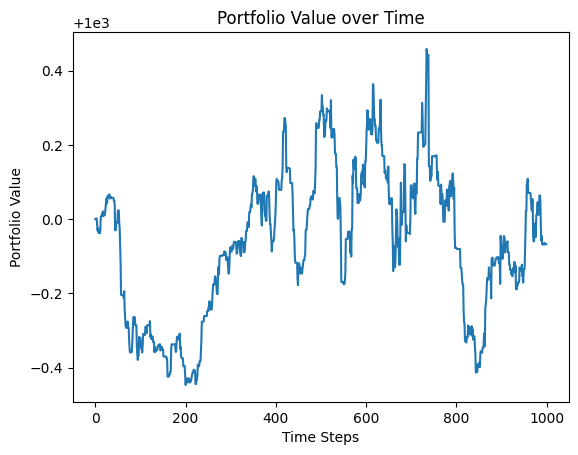

In [20]:
import matplotlib.pyplot as plt

portfolio_values = []

obs = env.reset()
portfolio_value = 1000

for _ in range(1000):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    
    portfolio_value += reward
    portfolio_values.append(portfolio_value)

    if done:
        break

plt.plot(portfolio_values)
plt.title('Portfolio Value over Time')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.show()

In [21]:
model = DQN('MlpPolicy', env, learning_rate=0.001, batch_size=32, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
from stable_baselines3 import PPO

model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("trading_agent_ppo")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1760 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.74e+03     |
|    ep_rew_mean          | 15.4         |
| time/                   |              |
|    fps                  | 1199         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0050028022 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | -5.96        |
|    learning_rate        | 0.0003       |
|    los

In [ ]:
import ta

for ticker in tickers:
    df = preprocessed_data[ticker]  # get the DataFrame
    
    # Add technical indicators
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()

    preprocessed_data[ticker] = df